# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training Agents using DDPG

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [5]:
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import ddpg_agent
import importlib
importlib.reload(ddpg_agent)

<module 'ddpg_agent' from 'C:\\udacity\\Reinforcement LEarning\\deep_rl_nd893-and-beyond\\p3_collab-compet\\ddpg_agent.py'>

In [6]:
class MultiAgents():
    def __init__(self,                  
                 state_size,
                 action_size,
                 num_agents,
                 random_seed,
                 buffer=None,
                 buffer_size=int(1e5),
                 batch_size=128,
                 gamma=0.99,
                 tau=1e-3,
                 lr_actor=1e-4,
                 lr_critic=1e-3,
                 weight_decay=0,
                 share_memmory=False):
        
        self.num_agents = num_agents;
        self.memory = None
        if share_memmory:
            self.memory = ddpg_agent.ReplayBuffer(action_size, buffer_size, batch_size, random_seed);
        
        self.agents = [ddpg_agent.Agent(state_size=state_size, 
              action_size=action_size,
              num_agents = 1,
              random_seed=2,
              buffer = self.memory,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay) for i in range(num_agents)];
    
    def reset(self):
        [agent.reset() for agent in self.agents];
    
    def step(self, states, actions, rewards, next_states, dones):
        [self.agents[i].step(states[i], actions[i], rewards[i], next_states[i], dones[i]) for i in range(self.num_agents)];
    
    def act(self, states):
        actions = [self.agents[i].act(np.array([states[i]])) for i in range(self.num_agents)];
        return actions;
    
    def save(self,run):
        [self.agents[i].save(run,i) for i in range(self.num_agents)]
        [self.agents[i].save(run,i) for i in range(self.num_agents)]
        
    def load(self,run):
        [self.agents[i].load(run,i) for i in range(self.num_agents)]
        [self.agents[i].load(run,i) for i in range(self.num_agents)]



In [7]:
def ddpg(agent, env_info, n_episodes=5000, max_t=1000, print_every=100, run=0):
    scores_deque = deque(maxlen=print_every)
    
    score = []
    solved = False
    for i_episode in range(1, n_episodes+1):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations              # get the current state
        agent.reset()
        for t in range(max_t):
            actions = agent.act(state)                    # select an action
            env_info = env.step(actions)[brain_name]      # send the action to the environment
            next_state = env_info.vector_observations     # get the next state
            reward = env_info.rewards                     # get the reward
            done = env_info.local_done                    # see if episode has finished
            agent.step(state, actions, reward, next_state, done)
            state = next_state
            scores += reward
            
            
            if np.any(done):
                break 
        scores_deque.append(np.mean(scores))
        score.append(np.mean(scores))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            agent.save(run)
        if (np.mean(scores_deque)>=0.5) & (not solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            solved = True
            
    return score

In [18]:
def playRun(run=0):
    max_t = 1000
    agent.load(run)

    for i in range(3):
        scores = np.zeros(num_agents)
        env_info = env.reset(train_mode=False)[brain_name] # reset the environment
        state = env_info.vector_observations               # get the current state
        agent.reset()
        for t in range(max_t):
            actions = agent.act(state,False)           # select an action
            env_info = env.step(actions)[brain_name]    # send the action to the environment
            next_state = env_info.vector_observations   # get the next state
            reward = env_info.rewards                   # get the reward
            done = env_info.local_done                  # see if episode has finished
            agent.step(state, actions, reward, next_state, done)
            state = next_state
            scores += reward


            if np.any(done):
                break 
        print("Score: {}".format(np.mean(scores)))

### 3.1 Learning Algorithm

The learning algorithm used to solve this learning is the DDPG algorithm described in the paper [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971)

This is a modification of the DQN algorithm that is extended to work for continuous output space. 
The DQN network from the previous lesson took an input, and predicted an action. however this agent needs to learn the appropriate force to apply to each joint of the robot arm. The force is a continuous variable from 0-1.

DDPG uses 2 networks, one to predict the action, and one to evaluate the action, and provide the contentious output.

**Hyperparameters:**
 
learningrate of 10e−4 and 10e−3 for the actor and critic respectively.  
For Q we included L2 weight decay of 0 and used a discount factor of γ = 0.99.
For the soft target updates we used τ = 0.001.
noise is added using an Ornstein-Uhlenbeck process (Uhlenbeck& Ornstein, 1930) with θ = 0.15 and σ = 0.2.
replay buffer size of 1e5  

**Network:**  
Actor(  
  (fc1): Linear(in_features=24, out_features=256, bias=True)  
  (fc2): Linear(in_features=256, out_features=256, bias=True)  
  (fc3): Linear(in_features=256, out_features=4, bias=True)  
)  
Actor has input matching the Environment, and output matching the output space

Critic(  
  (fcs1): Linear(in_features=52, out_features=256, bias=True)  
  (fc2): Linear(in_features=256, out_features=256, bias=True)  
  (fc3): Linear(in_features=256, out_features=1, bias=True)  
)  
Critic has input matching the Environment, and one output giving the size of the continuous action.

**Colaborative**  
The two agents shol learn to colaborate, and pass the ball over the net in a way thet the agent on the other side is able to pass the ball back.
Three experiments are tested out  
**Run 0:** the two agents are trained using seperate but equal networks, sharing thair experiences in a joined replay buffer, the teory behin tis is that the agents will learn faster as they both have doule as man xperiences to learn from  
**Run 1:** Same as above, but each agent gets it own replay buffer, should be able to get the same resoults just a bit slower  
**Run 2:** Agents are trained using same replay buffer, and using same network, if each agent, an the environment is seen from the eyes of the agent this should be possible, and train faster than the two above. howver if the environment is represented the same for both agents, this would have to b flipped for one of the agents in order to work.


In [9]:
# Hyperparameters for the agent parameters from example

buffer_size = int(1e5) # replay buffer size
batch_size = 256       # minibatch size
gamma = 0.99           # discount factor
tau = 1e-3             # for soft update of target parameters
lr_actor = 1e-4        # learning rate of the actor
lr_critic = 1e-3       # learning rate of the critic
weight_decay = 0       # L2 weight decay


agent = MultiAgents(state_size=state_size, 
              action_size=action_size,
              num_agents = num_agents,
              random_seed=2,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay,
              share_memmory=True
             )

Episode 100	Average Score: -0.00
Episode 200	Average Score: 0.000
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: 0.000
Episode 600	Average Score: 0.00
Episode 700	Average Score: 0.02
Episode 800	Average Score: 0.05
Episode 900	Average Score: 0.06
Episode 1000	Average Score: 0.06
Episode 1100	Average Score: 0.06
Episode 1200	Average Score: 0.06
Episode 1300	Average Score: 0.10
Episode 1400	Average Score: 0.13
Episode 1500	Average Score: 0.13
Episode 1600	Average Score: 0.15
Episode 1700	Average Score: 0.17
Episode 1800	Average Score: 0.18
Episode 1900	Average Score: 0.17
Episode 2000	Average Score: 0.24
Episode 2100	Average Score: 0.27
Episode 2200	Average Score: 0.30
Episode 2300	Average Score: 0.47
Episode 2400	Average Score: 0.41
Episode 2500	Average Score: 0.53
Episode 2600	Average Score: 0.57
Episode 2700	Average Score: 0.64
Episode 2800	Average Score: 0.45
Episode 2900	Average Score: 0.32
Episode 3000	Average Score: 0.33
Episode 3100	A

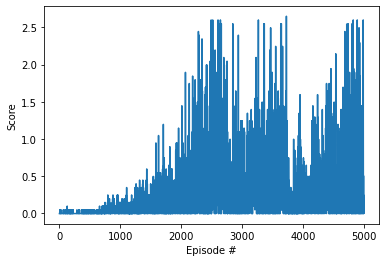

In [10]:
scores = ddpg(agent, env_info, run=0)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [19]:
playRun(0)

Score: -0.004999999888241291
Score: 2.600000038743019
Score: 2.650000039488077


In [12]:
# Hyperparameters for the agent parameters from example

buffer_size = int(1e5) # replay buffer size
batch_size = 256       # minibatch size
gamma = 0.99           # discount factor
tau = 1e-3             # for soft update of target parameters
lr_actor = 1e-4        # learning rate of the actor
lr_critic = 1e-3       # learning rate of the critic
weight_decay = 0       # L2 weight decay


agent = MultiAgents(state_size=state_size, 
              action_size=action_size,
              num_agents = num_agents,
              random_seed=2,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay,
              share_memmory=False
             )

Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: -0.00
Episode 600	Average Score: -0.00
Episode 700	Average Score: -0.00
Episode 800	Average Score: -0.00
Episode 900	Average Score: 0.010
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.04
Episode 1200	Average Score: 0.03
Episode 1300	Average Score: 0.05
Episode 1400	Average Score: 0.09
Episode 1500	Average Score: 0.10
Episode 1600	Average Score: 0.13
Episode 1700	Average Score: 0.12
Episode 1800	Average Score: 0.14
Episode 1900	Average Score: 0.20
Episode 2000	Average Score: 0.16
Episode 2100	Average Score: 0.27
Episode 2200	Average Score: 0.27
Episode 2300	Average Score: 0.18
Episode 2400	Average Score: 0.23
Episode 2500	Average Score: 0.19
Episode 2600	Average Score: 0.23
Episode 2700	Average Score: 0.24
Episode 2800	Average Score: 0.22
Episode 2900	Average Score: 0.29
Episode 3000	Average Score: 0.39
Episode 31

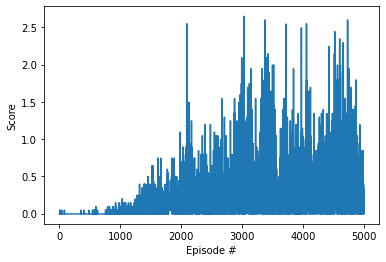

In [13]:
scores = ddpg(agent, env_info, run=1)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [20]:
playRun(1)

Score: 0.09500000160187483
Score: -0.004999999888241291
Score: -0.004999999888241291


In [15]:
# Hyperparameters for the agent parameters from example

buffer_size = int(1e5) # replay buffer size
batch_size = 256       # minibatch size
gamma = 0.99           # discount factor
tau = 1e-3             # for soft update of target parameters
lr_actor = 1e-4        # learning rate of the actor
lr_critic = 1e-3       # learning rate of the critic
weight_decay = 0       # L2 weight decay


agent = ddpg_agent.Agent(state_size=state_size, 
              action_size=action_size,
              num_agents = num_agents,
              random_seed=2,
              buffer_size = buffer_size,
              batch_size = batch_size,
              gamma = gamma,
              tau = tau,
              lr_actor = lr_actor,
              lr_critic = lr_critic,
              weight_decay = weight_decay
             )

Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: 0.010
Episode 500	Average Score: -0.00
Episode 600	Average Score: -0.00
Episode 700	Average Score: 0.000
Episode 800	Average Score: 0.02
Episode 900	Average Score: 0.05
Episode 1000	Average Score: 0.04
Episode 1100	Average Score: 0.08
Episode 1200	Average Score: 0.16
Episode 1300	Average Score: 0.50
Episode 1400	Average Score: 0.50
Episode 1500	Average Score: 0.43
Episode 1600	Average Score: 0.33
Episode 1700	Average Score: 0.48
Episode 1800	Average Score: 0.39
Episode 1900	Average Score: 0.32
Episode 2000	Average Score: 0.25
Episode 2100	Average Score: 0.34
Episode 2200	Average Score: 0.28
Episode 2300	Average Score: 0.47
Episode 2400	Average Score: 0.44
Episode 2500	Average Score: 0.39
Episode 2600	Average Score: 0.56
Episode 2700	Average Score: 0.47
Episode 2800	Average Score: 0.44
Episode 2900	Average Score: 0.60
Episode 3000	Average Score: 0.57
Episode 3100

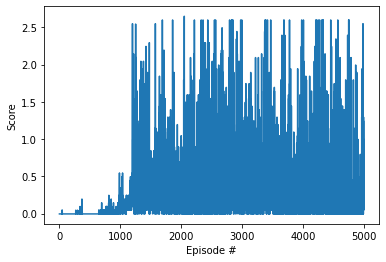

In [16]:
scores = ddpg(agent, env_info, run=2)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [23]:
playRun(2)

Score: 0.6450000097975135
Score: 0.1450000023469329
Score: 0.7450000112876296


## Conclussion
Looking at the training time of the 3 approaches, it is clear that a joind buffer lets the network train faster.

Run 2 was the network reaching a score of 0.5 fastest, and did it in 1300 episodes. This concludes that each agent sees the enironment from its own perspective, and thus the agents should act the sam given the same input.

One thing that is worth noticing is how the network plays after it is trained, either it drops the ball pretty much in the start, or it manages to get a hand on the ball and plays long balls back an furth, much like you would do it yourself if you played the game to get as many passes as possible.

If the agent manages to get the ball under controll, it most times plays to the end of the game.






## Future Work
- Further Hyperparameter Tuning
- Try algorithm on additional environment like the Soccer environment
- Try out other algorithms, MADDPG or Multi-Agent DDPG. This [paper](https://papers.nips.cc/paper/7217-multi-agent-actor-critic-for-mixed-cooperative-competitive-environments.pdf) describes how information about the other agents states is used during training. this should improve training and perform better
- Add more random actions to make the agents explore more, it looks like it only learns to take the ball from its initial position, and then plays long balls.
- Change the rules of the game to make the agents challange eachother, revording the agent that manages to get the ball to land on the other agents playingfield.

